Explore Features with Gradient Tree Boosting
============================================

There are roughly 30 features generated from the data cleaning script. This model will explore feature performance through training and tuning a gradient boosting classifier model.

In [1]:
# set up code and dataframe with training data
import pandas as pd
import numpy as np
import statistics as st

import sklearn.metrics as ms
import sklearn.ensemble as en
import sklearn.model_selection as mds
import matplotlib.pyplot as plt

from scipy import interpolate

datestamp = "20250308.123938"
df_ = pd.read_csv(f"../data/kaggle/train.clean.{datestamp}.csv")
print(df_.shape)

(891, 66)


In [2]:
#all_columns = True
all_columns = False

if all_columns:
    columns_to_drop = [ "Survived", "Name", "Title", "TitleGrouped", "LastName", "Cabin", 
                        "Ticket", "Sex", "Age", "Embarked", "PassengerId", "CabinDeck",
                        "CabinRoom", "SurvivorCount" ]
    columns_to_drop += [ "AgeImputed", "FarePerPerson", "FppMinMax", "SibSp", "Parch", "SexOrd", 
                         "AgeMinMax", "TicketConfirmedSurvived", "GroupSurvived",
                         "TicketConfirmedDied", "GroupDied", "Died" ]
    x_colnames = [i for i in df_.columns if i not in columns_to_drop]
else:
    x_colnames = [  "P3orDeadTitle", "Pclass3", "EmbarkOrd", "SmallGroup", "AgeImputed" ]


y_colname = [ "Survived" ]

X = df_[ x_colnames ]
y = df_[ y_colname ].values.ravel()

print(X.info())

# Assuming you have your features in X and your target variable in y
X_train, X_test, y_train, y_test = mds.train_test_split(X, y, test_size=0.2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   P3orDeadTitle  891 non-null    int64  
 1   Pclass3        891 non-null    int64  
 2   EmbarkOrd      891 non-null    float64
 3   SmallGroup     891 non-null    int64  
 4   AgeImputed     891 non-null    float64
dtypes: float64(2), int64(3)
memory usage: 34.9 KB
None


In [3]:
num_folds = 5
s_scoring = "balanced_accuracy"

param_dist = {
    'learning_rate':     [ 0.1 ],
    'max_features':      [ 3 ],
    'n_estimators':      [ 15 ],
    'max_depth':         [ 6 ],
    'min_samples_split': [ 40 ],
    'min_samples_leaf':  [ 25 ],
    'subsample':         [ 0.7 ],
}

gb_clf = en.GradientBoostingClassifier()
random_search = mds.GridSearchCV( estimator=gb_clf,
                                        param_grid=param_dist,
                                        cv=num_folds,
                                        scoring=s_scoring,
                                        n_jobs=-1 )

random_search.fit(X_train, y_train)
best_params = random_search.best_params_
model = random_search.best_estimator_

print(f"Best Params: {best_params}")

Best Params: {'learning_rate': 0.1, 'max_depth': 6, 'max_features': 3, 'min_samples_leaf': 25, 'min_samples_split': 40, 'n_estimators': 15, 'subsample': 0.7}


In [4]:
importances = model.feature_importances_
feature_imp_df = pd.DataFrame(
    {'Feature': x_colnames, 'Gini Importance': importances} ).sort_values(
         'Gini Importance', ascending=False)

feature_imp_df

,Feature,Gini Importance
0,P3orDeadTitle,0.619746
1,Pclass3,0.156591
4,AgeImputed,0.094436
3,SmallGroup,0.094152
2,EmbarkOrd,0.035075


In [5]:
y_train_preds_proba = model.predict_proba(X_train)

train_fpr, train_tpr, train_thresh = ms.roc_curve(y_train, y_train_preds_proba[:,1])
train_roc_auc = ms.auc(train_fpr, train_tpr)

# Calculate the geometric mean
gmeans = np.sqrt(train_tpr * (1 - train_fpr))

# Locate the index of the largest gmean
index = np.argmax(gmeans)
train_threshold = train_thresh[index]

train_tpr_intrp = interpolate.interp1d(train_thresh, train_tpr)
train_fpr_intrp = interpolate.interp1d(train_thresh, train_fpr)

print(f"Train AUC {round(train_roc_auc,3)}")
print(f"Train optimal threshold {round(train_threshold,3)} at " \
      f"tpr: {np.round(train_tpr_intrp(train_threshold),3)}, " \
      f"fpr: {np.round(train_fpr_intrp(train_threshold),3)}")

Train AUC 0.892
Train optimal threshold 0.334 at tpr: 0.794, fpr: 0.139


In [6]:
# calculate test ROC curve
y_test_preds_proba  = model.predict_proba(X_test)

test_fpr, test_tpr, test_thresh = ms.roc_curve(y_test, y_test_preds_proba[:,1])
test_roc_auc = ms.auc(test_fpr, test_tpr)

# Calculate the geometric mean
test_gmeans = np.sqrt(test_tpr * (1 - test_fpr))

# Locate the index of the largest gmean
test_index = np.argmax(test_gmeans)
test_threshold = test_thresh[test_index]

test_tpr_intrp = interpolate.interp1d(test_thresh, test_tpr)
test_fpr_intrp = interpolate.interp1d(test_thresh, test_fpr)

print(f"Test AUC {round(test_roc_auc,3)}")
print(f"Test optimal threshold {round(test_threshold,3)} at " \
      f"tpr: {np.round(test_tpr_intrp(test_threshold),3)}, " \
      f"fpr: {np.round(test_fpr_intrp(test_threshold),3)}")

Test AUC 0.848
Test optimal threshold 0.343 at tpr: 0.77, fpr: 0.161


In [7]:
# if necessay, override the threshold point
#test_threshold = 0.6

In [8]:
# Define the desired operating point (FPR, TPR)
test_operating_point_fpr = test_fpr_intrp(test_threshold)
test_operating_point_tpr = test_tpr_intrp(test_threshold)

# Find the closest threshold to the desired operating point
distances = (test_fpr - test_operating_point_fpr)**2 + (test_tpr - test_operating_point_tpr)**2
closest_index = distances.argmin()
test_operating_point_threshold = test_thresh[closest_index]

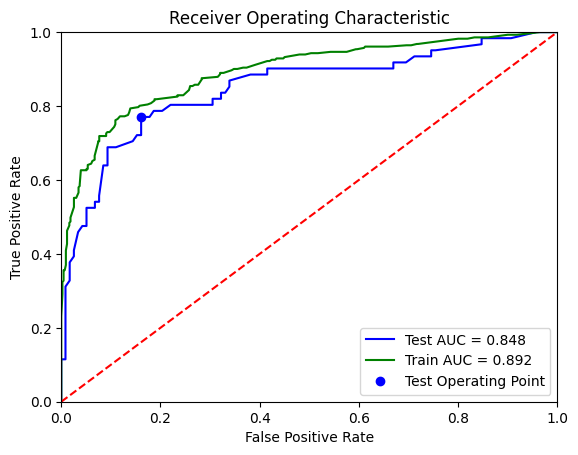

In [9]:
plt.title('Receiver Operating Characteristic')

plt.plot(test_fpr, test_tpr, 'b', label = 'Test AUC = %0.3f' % test_roc_auc)
plt.plot(train_fpr, train_tpr, 'g', label = 'Train AUC = %0.3f' % train_roc_auc)
plt.plot([0, 1], [0, 1],'r--')

plt.plot(test_operating_point_fpr,test_operating_point_tpr, 'bo', label=f'Test Operating Point')
#plt.plot(train_operating_point_fpr,train_operating_point_tpr, 'go', label=f'Train Operating Point')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc = 'lower right')
plt.show()

In [10]:
y_test_preds = (y_test_preds_proba[:,1] > test_threshold).astype(int)

tn, fp, fn, tp = ms.confusion_matrix(y_test, y_test_preds).ravel()
print(f"Confusion Matrix, at Threshold {test_threshold:.3f}")
print(f"  tn {tn:<3}  fp {fp:<3}")
print(f"  fn {fn:<3}  tp {tp:<3}")
print()

bal_acc   = round( ms.balanced_accuracy_score( y_test, y_test_preds ), 3 )
precision = round( ms.precision_score( y_test, y_test_preds ), 3 )
recall    = round( ms.recall_score( y_test, y_test_preds ), 3 )
f1        = round( ms.f1_score( y_test, y_test_preds, average='micro' ), 3 )

s_scores = f"Bal Acc: {bal_acc}, Pre: {precision}, Rec: {recall}, F1 Micro: {f1}"
print(s_scores)
print()

l_raw_scores = mds.cross_val_score(model, X_test, y_test, scoring=s_scoring, cv=num_folds)
l_scores = [ round(i, 2) for i in l_raw_scores ]

mean_score = round(st.mean(l_scores), 3)
std_score = round(st.stdev(l_scores), 3)

print(f"{num_folds}-fold {s_scoring} mean: {mean_score}, stdev: {std_score}")
print(f"  each: {l_scores}")

Confusion Matrix, at Threshold 0.343
  tn 99   fp 19 
  fn 17   tp 44 

Bal Acc: 0.78, Pre: 0.698, Rec: 0.721, F1 Micro: 0.799

5-fold balanced_accuracy mean: 0.734, stdev: 0.089
  each: [np.float64(0.69), np.float64(0.83), np.float64(0.65), np.float64(0.67), np.float64(0.83)]


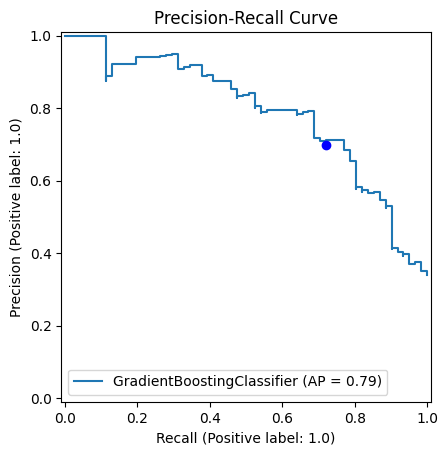

In [11]:
# Plot the precision-recall curve
display = ms.PrecisionRecallDisplay.from_estimator(model, X_test, y_test)
plt.title('Precision-Recall Curve')
plt.plot(recall, precision, 'bo', label=f'Test Operating Point')
plt.show()

In [28]:
df_test = pd.read_csv(f"../data/kaggle/test.clean.{datestamp}.csv")

y_proba = model.predict_proba(df_test[x_colnames])
y_preds = (y_proba[:,1] >= test_threshold).astype(int)

df_test["SurvivedProbability"] = y_proba[:,1]
df_test["Survived"] = y_preds

offset = 0.015

df_test_sub = df_test[ (df_test["SurvivedProbability"] <= test_threshold + offset) & \
                       (df_test["SurvivedProbability"] >= test_threshold - offset ) ] \
                .sort_values(by="SurvivedProbability", ascending=True) \
                .reset_index()

df_closest = df_test_sub.iloc[(df_test_sub["SurvivedProbability"] - test_threshold).abs().argsort()]

df_closest[[ "Pclass", "LastName", "Title", "Sex", "Age", "Cabin", "Ticket", "Embarked", "FarePerPerson", "SurvivedProbability", "Survived" ]]

,Pclass,LastName,Title,Sex,Age,Cabin,Ticket,Embarked,FarePerPerson,SurvivedProbability,Survived
17,3,Riihivouri,Miss,female,22.0,NaN,3101295,S,5.6696,0.342986,1
16,3,Drapkin,Miss,female,23.0,NaN,SOTON/OQ 392083,S,8.0500,0.342986,1
15,3,Lundin,Miss,female,23.0,NaN,347469,S,7.8542,0.342986,1
14,3,Hellstrom,Miss,female,22.0,NaN,7548,S,8.9625,0.342986,1
13,3,Oreskovic,Miss,female,23.0,NaN,315085,S,8.6625,0.342986,1
18,3,Kink,Miss,female,22.0,NaN,315152,S,8.6625,0.342986,1
12,3,Nilsson,Miss,female,18.0,NaN,347066,S,7.7750,0.335521,0
11,3,Badman,Miss,female,18.0,NaN,A/4 31416,S,8.0500,0.335521,0
19,1,Williams,Mr,male,21.0,NaN,PC 17597,C,30.6896,0.352705,1
10,3,Sage,Miss,female,NaN,NaN,CA. 2343,S,6.3227,0.330980,0


## Write Output to File

In [ ]:
df_test[["PassengerId", "Survived"]].to_csv(f"../data/kaggle/submit.boosting.csv", index=False)